In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations tensorflow


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb

In [4]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Vishal\.labelmerc


In [3]:
# Avoid Out Of Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#for moving lables
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [4]:
#for image augmentor
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [5]:
#augmentor pipeline
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Side_Face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


In [6]:
#loding dataset into tensorflow
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

train_images = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
#labelling
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

train_labels = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('/Users/aadityapaliwal/Side Face Detection Project/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [8]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(12660, 12660, 2820, 2820, 2700, 2700)

In [9]:
#finalizing dataset
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(13000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(4000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(4000)
val = val.batch(8)
val = val.prefetch(4)

2023-10-08 11:04:03.913125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 7706 of 13000
2023-10-08 11:04:10.323247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


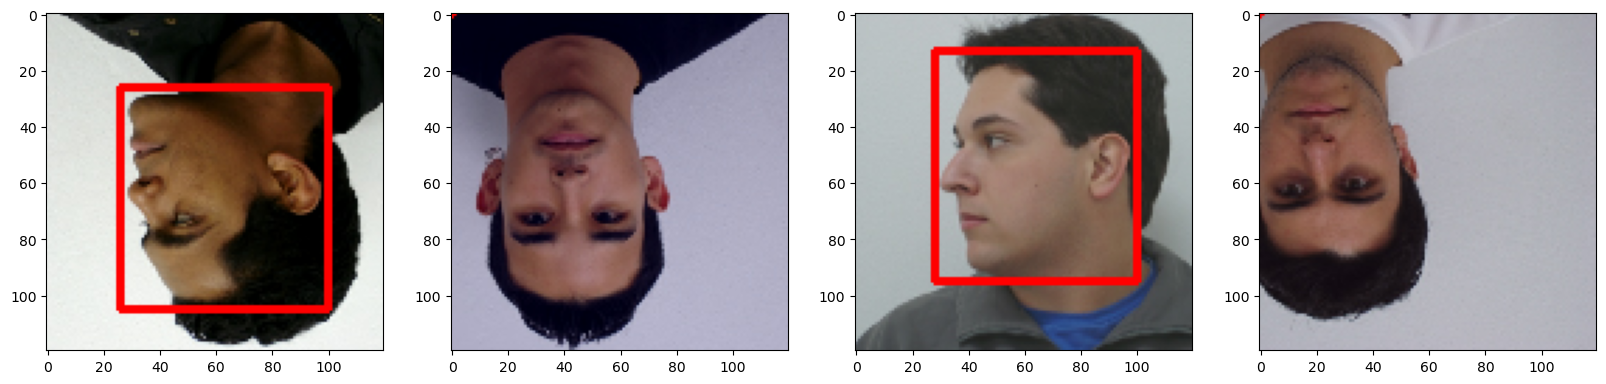

In [ ]:
#testing

data_samples = train.as_numpy_iterator()

res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [12]:
#Deep learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#using vgg16 

vgg = VGG16(include_top=False)

#both classification and regression

def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

facetracker = build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [13]:
#defining loss
X, y = train.as_numpy_iterator().next()
classes, coords = facetracker.predict(X)

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

2023-10-08 11:05:34.874481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 7552 of 13000
2023-10-08 11:05:41.994089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-08 11:05:42.366951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(), dtype=float32, numpy=7.7847967>

In [14]:
#*training

class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
    
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#do not run while ***
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2023-10-08 11:06:45.840124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 7386 of 13000
2023-10-08 11:06:53.024133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 246s 137ms/step - total_loss: 0.1237 - class_loss: 0.0324 - regress_loss: 0.1075 - val_total_loss: 0.0066 - val_class_loss: 2.1339e-04 - val_regress_loss: 0.0065
Epoch 2/10
1583/1583 [==============================] - 224s 135ms/step - total_loss: 0.0155 - class_loss: 2.8084e-04 - regress_loss: 0.0154 - val_total_loss: 0.0055 - val_class_loss: 8.2179e-05 - val_regress_loss: 0.0055
Epoch 3/10


2023-10-08 11:14:34.891557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10294 of 13000
2023-10-08 11:14:36.961975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 250s 150ms/step - total_loss: 0.0087 - class_loss: 6.3741e-05 - regress_loss: 0.0086 - val_total_loss: 0.0240 - val_class_loss: 6.7795e-05 - val_regress_loss: 0.0239
Epoch 4/10


2023-10-08 11:18:45.010259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10096 of 13000
2023-10-08 11:18:47.299859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 254s 153ms/step - total_loss: 0.0094 - class_loss: 6.6646e-05 - regress_loss: 0.0094 - val_total_loss: 0.0222 - val_class_loss: 2.9684e-05 - val_regress_loss: 0.0222
Epoch 5/10


2023-10-08 11:22:58.917475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10476 of 13000
2023-10-08 11:23:00.834150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 251s 151ms/step - total_loss: 0.0120 - class_loss: 3.6262e-04 - regress_loss: 0.0118 - val_total_loss: 0.0013 - val_class_loss: 5.4241e-06 - val_regress_loss: 0.0013
Epoch 6/10


2023-10-08 11:27:10.355443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10520 of 13000


   1/1583 [..............................] - ETA: 5:16:43 - total_loss: 0.0105 - class_loss: 3.5512e-05 - regress_loss: 0.0104

2023-10-08 11:27:12.225467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 248s 149ms/step - total_loss: 0.0144 - class_loss: 0.0029 - regress_loss: 0.0130 - val_total_loss: 0.0120 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0120
Epoch 7/10


2023-10-08 11:31:18.789284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10503 of 13000


   1/1583 [..............................] - ETA: 5:17:05 - total_loss: 0.0097 - class_loss: 2.9802e-08 - regress_loss: 0.0096

2023-10-08 11:31:20.668535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 248s 149ms/step - total_loss: 0.0064 - class_loss: 9.2321e-06 - regress_loss: 0.0064 - val_total_loss: 0.0083 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0083
Epoch 8/10


2023-10-08 11:35:27.277997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10540 of 13000


   1/1583 [..............................] - ETA: 5:19:08 - total_loss: 0.0102 - class_loss: 0.0000e+00 - regress_loss: 0.0102

2023-10-08 11:35:29.233078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 247s 149ms/step - total_loss: 0.0173 - class_loss: 0.0026 - regress_loss: 0.0160 - val_total_loss: 0.0173 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0173
Epoch 9/10


2023-10-08 11:39:34.611774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10757 of 13000


   1/1583 [..............................] - ETA: 5:11:01 - total_loss: 0.0159 - class_loss: 4.3213e-07 - regress_loss: 0.0159

2023-10-08 11:39:36.256146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 246s 148ms/step - total_loss: 0.0125 - class_loss: 0.0011 - regress_loss: 0.0120 - val_total_loss: 0.0035 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0035
Epoch 10/10


2023-10-08 11:43:40.282461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 10746 of 13000


   1/1583 [..............................] - ETA: 5:11:40 - total_loss: 0.0162 - class_loss: 0.0000e+00 - regress_loss: 0.0162

2023-10-08 11:43:41.950373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1583/1583 [==============================] - 247s 149ms/step - total_loss: 0.0092 - class_loss: 3.2526e-06 - regress_loss: 0.0092 - val_total_loss: 0.0051 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0051


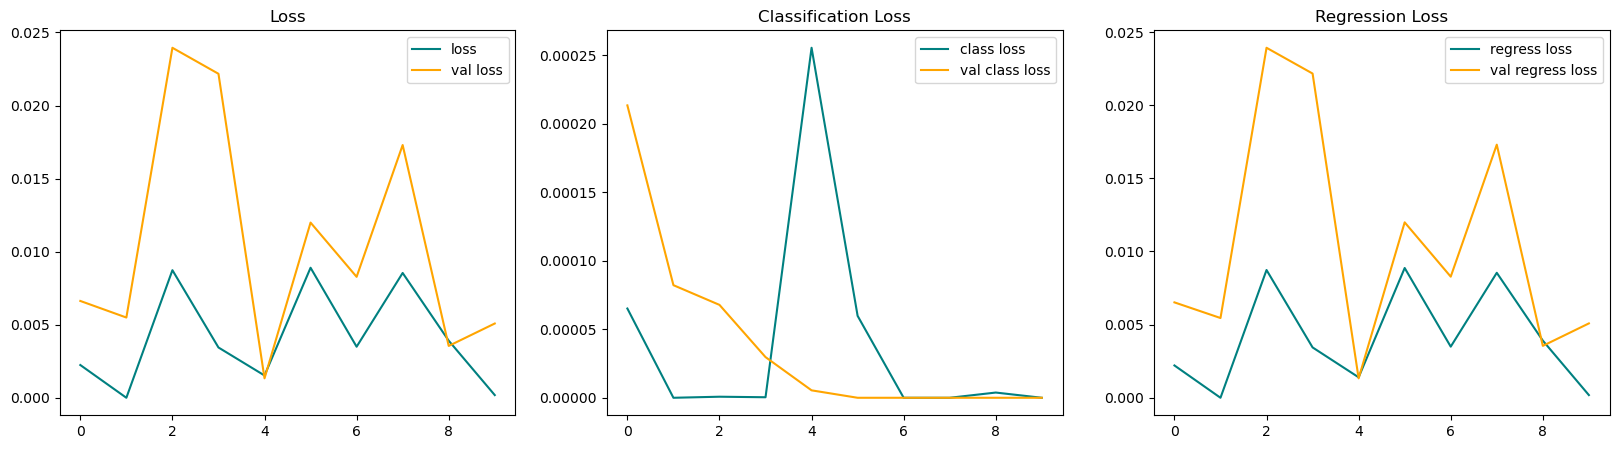

In [15]:
#plotting the loss with normal and val

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


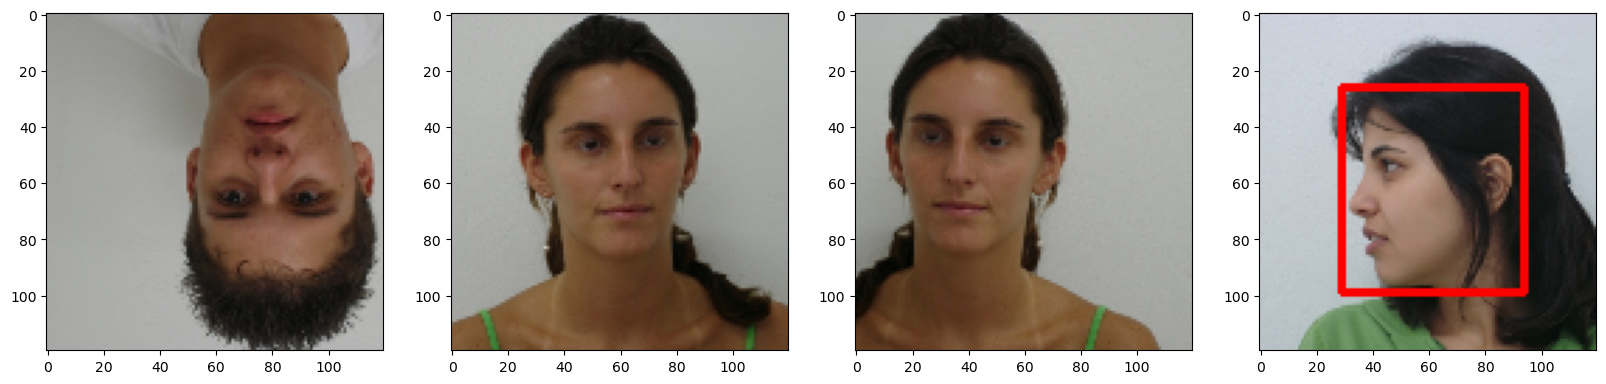

In [ ]:
#testing 2 like a good dev

test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [19]:
#saving
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')

In [20]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [14]:
# #finally sleepcv2

# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     _ , frame = cap.read()
#     frame = frame[50:500, 50:500,:]
    
#     rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     resized = tf.image.resize(rgb, (120,120))
    
#     yhat = facetracker.predict(np.expand_dims(resized/255,0))
#     sample_coords = yhat[1][0]
    
#     if yhat[0] > 0.5: 
#         # Controls the main rectangle
#         cv2.rectangle(frame, 
#                       tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
#                             (255,0,0), 2)
#         # Controls the label rectangle
#         cv2.rectangle(frame, 
#                       tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
#                                     [0,-30])),
#                       tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
#                                     [80,0])), 
#                             (255,0,0), -1)
        
#         # Controls the text rendered
#         cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
#                                                [0,-5])),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
#     cv2.imshow('EyeTrack', frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


In [21]:
import cv2
import numpy as np
import tensorflow as tf

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    height, width, _ = frame.shape
    
    # Define the cropping dimensions (adjust these as needed)
    crop_size = 450  # Change this value to adjust the size of the cropped region
    
    # Calculate the coordinates for cropping
    top_left = ((height - crop_size)//2, (width - crop_size)//2)
    bottom_right = (top_left[0] + crop_size, top_left[1] + crop_size)
    
    # Crop the frame
    frame = frame[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1], :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [crop_size, crop_size]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [crop_size, crop_size]).astype(int)), 
                            (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [crop_size, crop_size]).astype(int), 
                                    [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [crop_size, crop_size]).astype(int),
                                    [80, 0])), 
                            (255, 0, 0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Side Face', tuple(np.add(np.multiply(sample_coords[:2], [crop_size, crop_size]).astype(int),
                                               [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
